In [1]:
import argparse
import os
import sys
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image, ImageOps
import pandas as pd
from tqdm import tqdm
import json

from torch.backends import cudnn
import torch
import torch.nn.functional as F
from torchvision import transforms as T

sys.path.append('.')
from reid import build_encoder
from utils import *
from sort import preprocessing
from sort import nn_matching
from sort.detection import Detection
from sort.tracker import Tracker

/home/fan/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


# Initialization top-view deep-sort

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="7"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cudnn.benchmark = True
encoder = build_encoder()
encoder.load_param('reid/reid.pth')
encoder.to(device)
encoder.eval()

# Definition of the tracking parameters
nn_budget = 100 # maximun person to keep
max_cosine_distance = 0.5 # by our re-id model
metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)

# Load top-view detection

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((128,64)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [5]:
pano_detection = pd.read_pickle("./data/pano_detection_1.pkl")
Video = pd.read_pickle("./data/video_1.pkl", compression='zip') 

# Tracking


  0%|          | 0/624 [00:00<?, ?it/s]

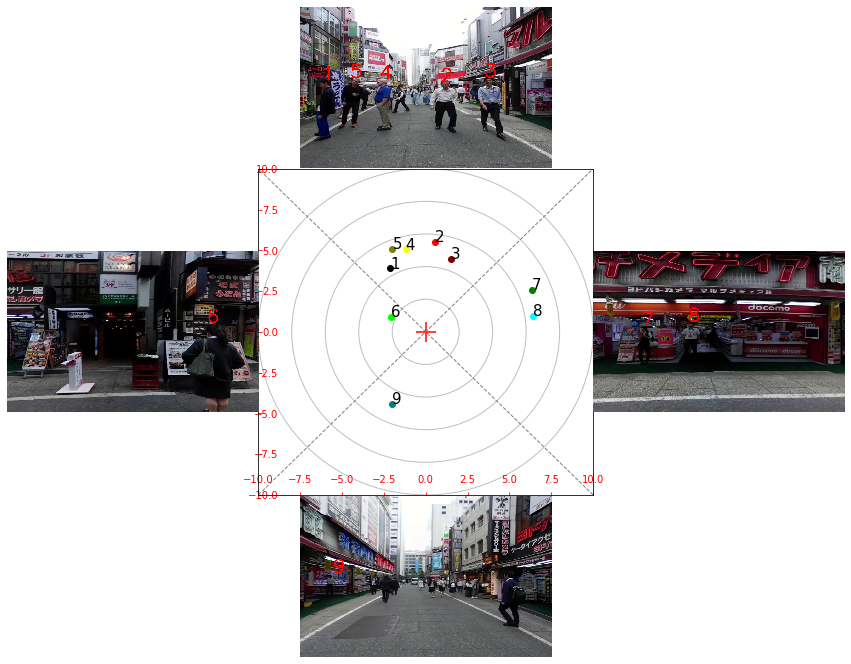


  0%|          | 3/624 [00:01<03:54,  2.65it/s]

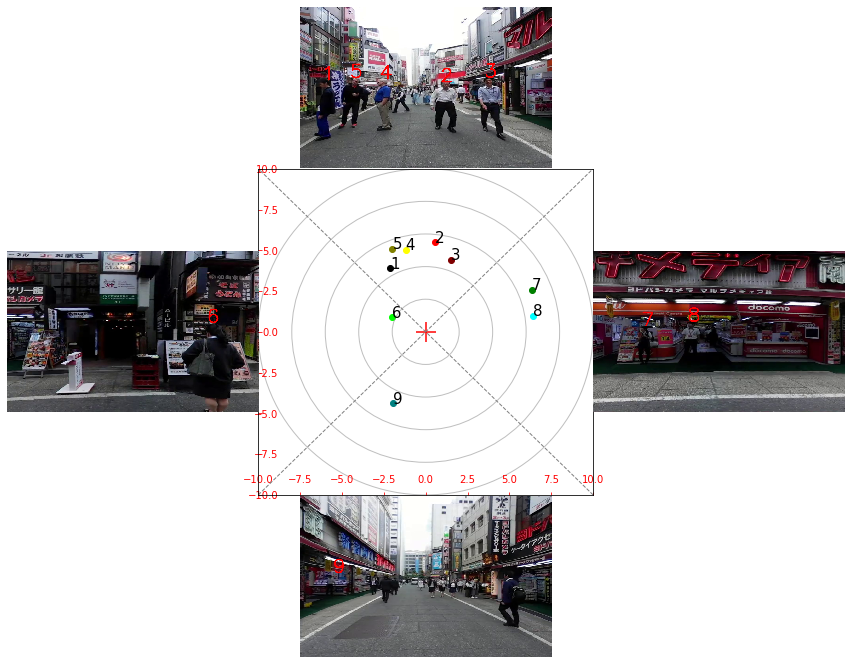


  1%|          | 4/624 [00:02<05:48,  1.78it/s]

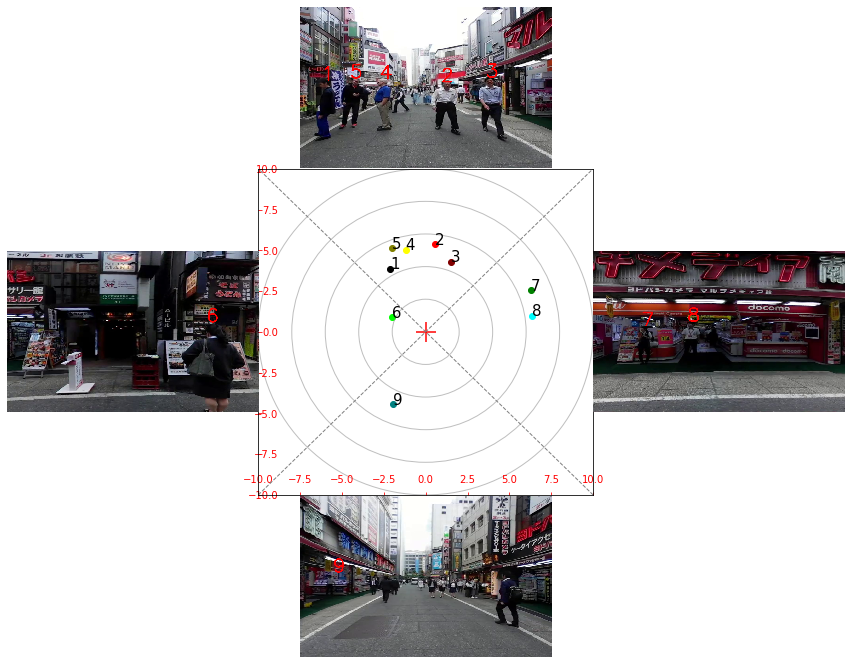


  1%|          | 5/624 [00:02<06:32,  1.58it/s]

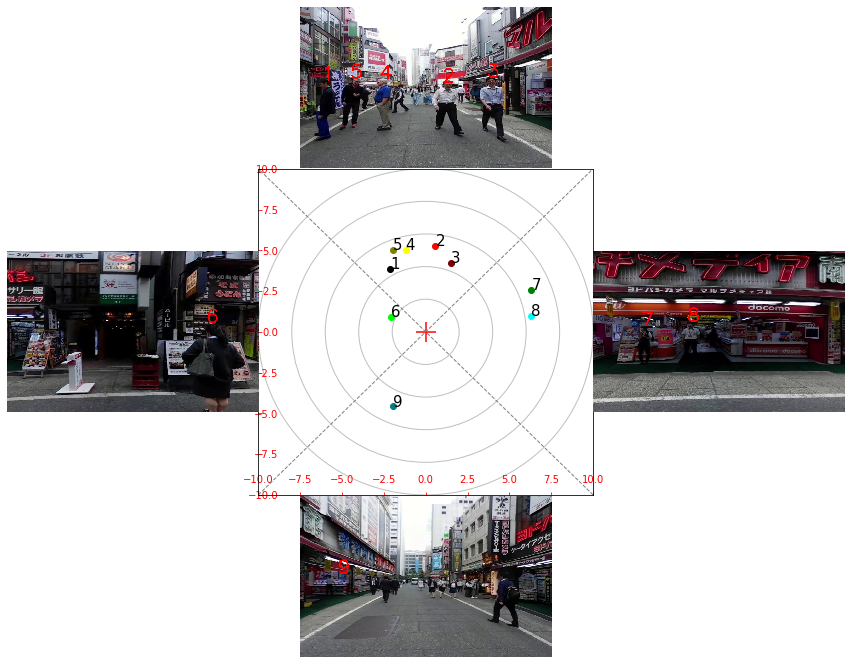


  1%|          | 6/624 [00:03<07:03,  1.46it/s]

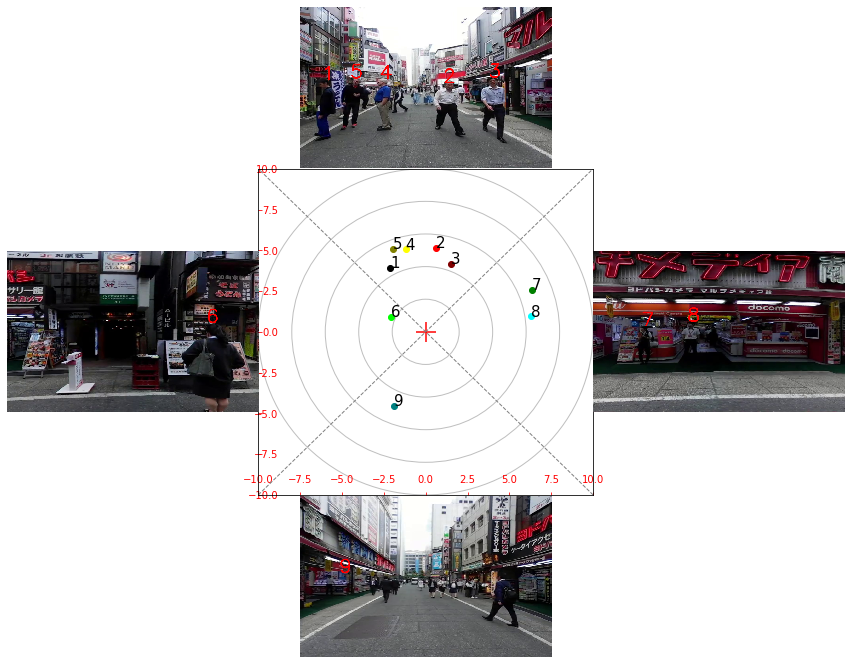


  1%|          | 7/624 [00:04<07:31,  1.37it/s]

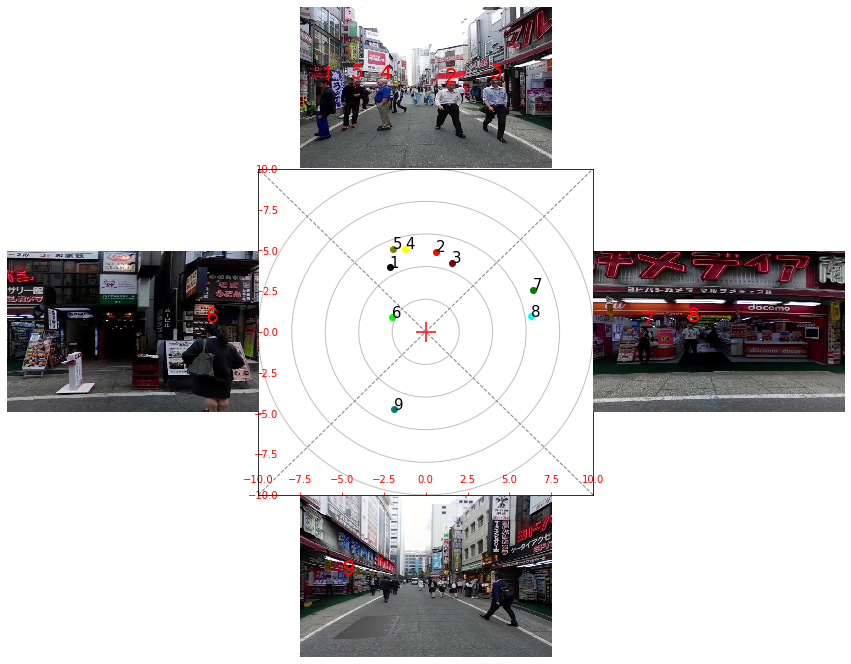


  1%|▏         | 8/624 [00:05<08:16,  1.24it/s]

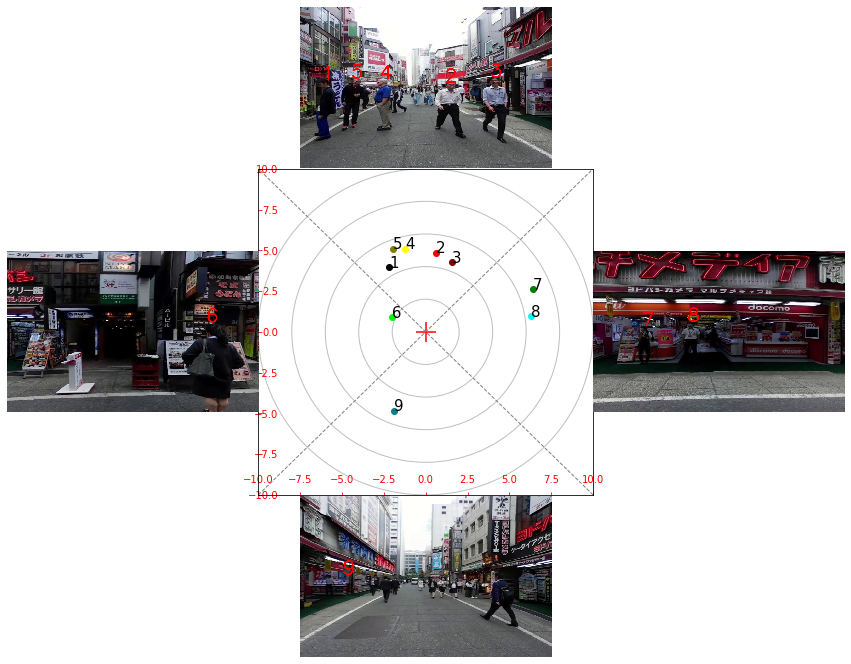


  1%|▏         | 9/624 [00:06<09:15,  1.11it/s]

KeyboardInterrupt: 

<Figure size 1080x864 with 0 Axes>

In [7]:
# Initilize tracker
tracker = Tracker(metric=metric, max_iou_distance=0.8, max_age=50, n_init=3)
frame_list = list(pano_detection.keys())
pano_tracks = {}
pano_bridges = {}

for frame in tqdm(frame_list):
    patches = []
    boxes = []
    for person in pano_detection[frame]:
        box_wh = 1
        patches.append(transform(person[5]))
        boxes.append(np.array([person[1]-box_wh, person[2]-box_wh, box_wh*2, box_wh*2]))  
    
    boxes = np.array(boxes)
    patches = torch.stack(patches)
    
    # Encoding each patch to 2048 vectors
    feats = encoder(patches.cuda())
    feats = F.normalize(feats, p=2, dim=1)
    feats = feats.cpu().detach().numpy()

    # Initilize the detection in deep_sort, it does nothing here since we already has done nms
    detections = [Detection(box, 1.0, feat) for box, feat in zip(boxes,feats)]
    tracker.predict()
    tracker.update(detections)    

    pano_locations = []
    for track in tracker.tracks:
        if not track.is_confirmed() or track.time_since_update > 1:
            continue 
        box = track.to_tlbr()
        track_id = track.track_id
        pano_locations.append([(box[2]+box[0])/2, (box[3]+box[1])/2,int(track_id)])
    
    if len(pano_locations)>0:
        #connect to the img boxes    
        #pano_locations = np.stack(pano_locations)
        loc_dets = np.stack([pano_det[1],pano_det[2]] for pano_det in pano_detection[frame])
        pano_bridge = []
        for loc_track in pano_locations:
            ind = np.sum(np.abs(loc_track[:2]-loc_dets),axis=1).argmin()
            pano_bridge.append([pano_detection[frame][ind][0], pano_detection[frame][ind][4].tolist(),loc_track[2]])
     
        pano_tracks[frame] = pano_locations
        pano_bridges[frame] = pano_bridge
        
        Images = Video[str(frame)]
        
        plot_pano_tracking(frame, pano_locations, pano_bridge, Images)

with open('./data/pano_tracks_1.json', 'w') as fp:
    json.dump(pano_tracks, fp)
    
with open('./data/pano_bridges_1.json', 'w') as fp:
    json.dump(pano_bridges, fp)    
    